In [1]:
from IPython import display

# Domestic Perception Functionalities
We will mostly focus on Object Detection, since person recognition is somewhat separated from the other components, and should be refactored to use `mas_perception` architecture.

The code portions in this tutorial for the [Pose Estimation](#Pose-Estimation) section assume successful installation of the ROS packages [`mas_perception_libs`](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/), and Python dependencies `NumPy` & `matplotlib`.

The code in the [SSD Object Detection](#SSD-Object-Detection) section assumes installation of  [`ssd_keras_ros`](https://github.com/minhnh/ssd_keras_ros), Python dependencies `Keras`, `tensorflow` & `tqdm`, and Git LFS initialization (also described in the package documentation).

Because of ROS limitations, Python 2 kernel should be used in order for the ROS packages to load properly.

## Table of contents
* [Overview](#Overview)
    - [Object Detection](#Object-Detection)
    - [Object Recognition](#Object-Recognition)
* [`mas_perception_libs`](#mas_perception_libs)
    - [Pose Estimation](#Pose-Estimation)
    - [SSD Object Detection](#SSD-Object-Detection)
    - [Point Cloud Processing](#Point-Cloud-Processing)

## Overview
### Object Detection
Previously, object detection in `mcr_scene_segmentation` and the built-in `tabletop_segmentator` on the HSR has the following general structure

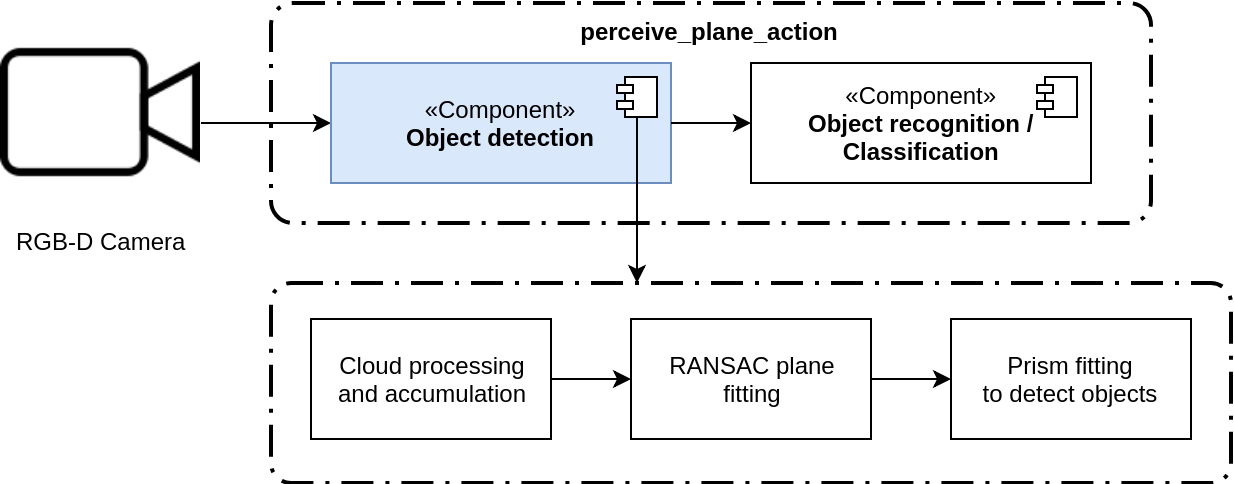

In [2]:
display.Image('images/perception_arch_detection_old.png', width=600)

On the @Home team, this architecture was modified like in the following figure:

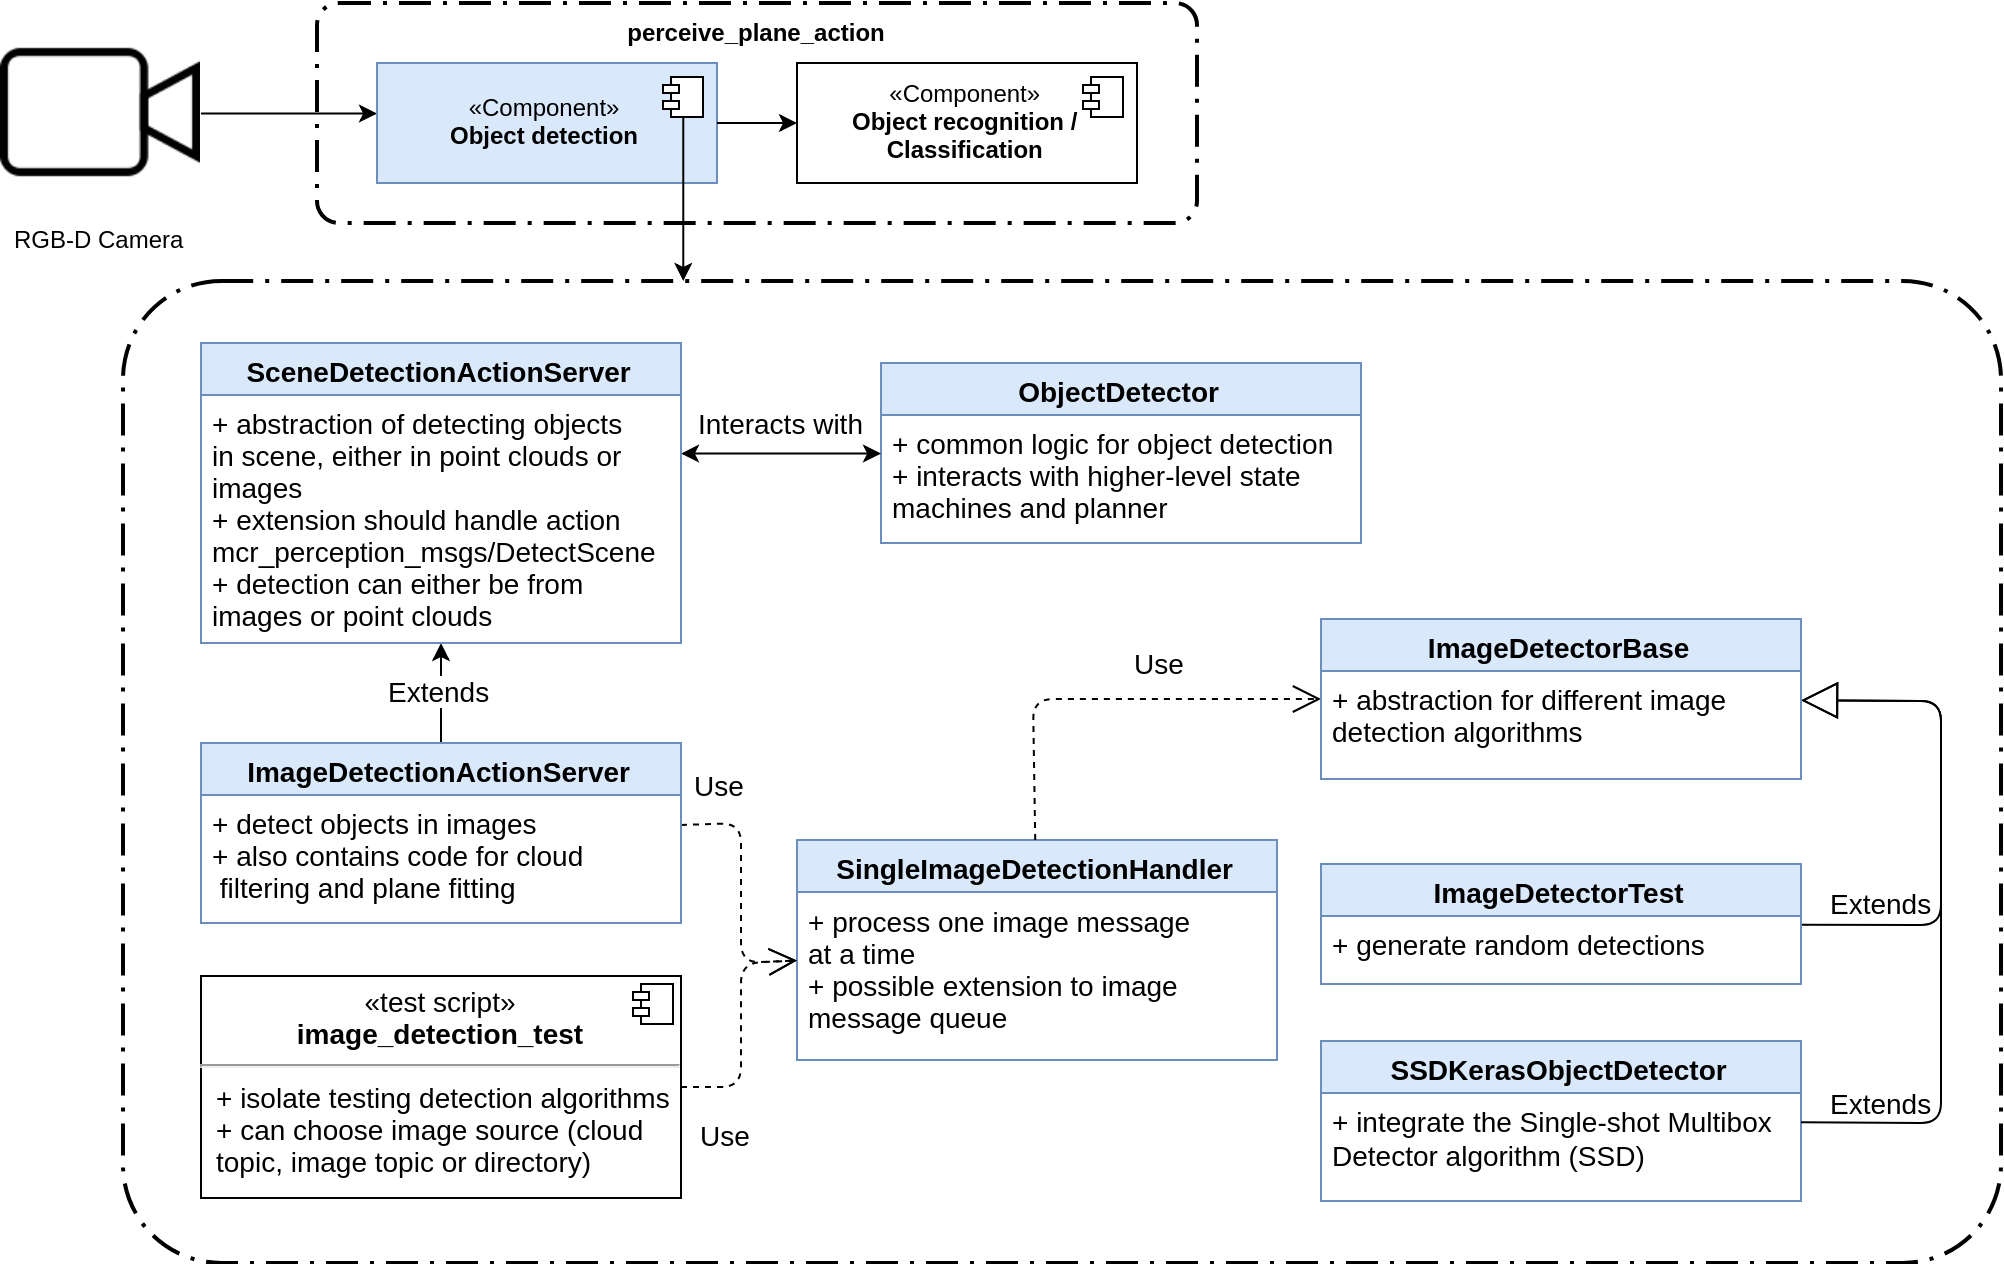

In [3]:
display.Image('images/perception_arch_detection_new.png')

There are several motivations for moving away from the older solution and going for for this design:
* Relying solely on point clouds for detection is not always reliable, especially in domestic environment, because of the variety of materials and object shapes. For example, RGB-D cameras have a particularly hard time with plastic objects, as can be seen in the following figure
* Exciting new detection algorithms tend to deal with RGB-only images which wouldn't be affected by object materials. However, many of these use deep learning (DL) libraries in Python, whereas the old detection code is written in C++.
* The fast moving pace of DL demands some form of abstraction for easing integration of new algorithms


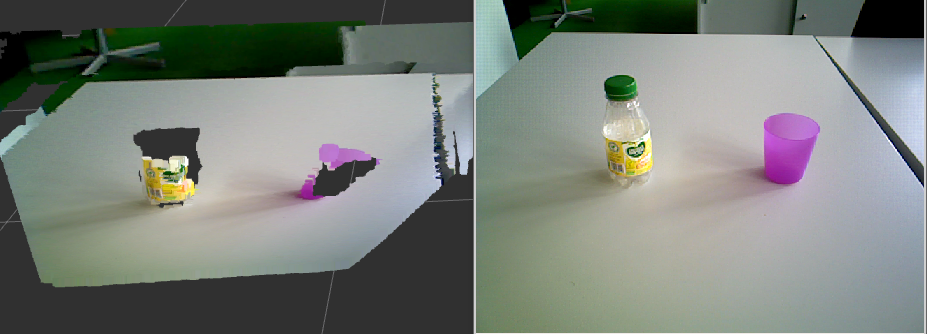

In [4]:
display.Image('images/bad_objects.png')

With the above points in mind, the main features of this architecture are:
* `ObjectDetector` (see [Python documentation](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/docs/python_package.md#objectdetector) for more details) is an abstraction which interacts with higher-level state machine and planning logic.
    - It also works with the HSR built-in `tabletop_segmentator` component (this has not been tested since mid 2018, however).
    - A similar detection action server which uses `mcr_scene_segmentation` can be implemented without much effort and would be able to interact with `ObjectDetector`, as long as it properly handles the action defined in [`mcr_perception_msgs/DetectScene.action`](https://github.com/b-it-bots/mas_perception/blob/kinetic/mcr_perception_msgs/action/DetectScene.action).
* `SceneDetectionAction` is an abstraction for a handler of the `mcr_perception_msgs/DetectScene` action. The interaction with HSR's `tabletop_segmentator`, for example, is handled in an extension of this class. Extensions of this class are meant to have direct access to sensor topics for efficiency.
* `ImageDetectorBase` (see [Python documentation](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/docs/python_package.md#imagedetectorbase) for more details) is an abstraction for different image detection algorithms, which would hopefully ease the integration of new algorithms in the future.

Possible improvements for the object detection architecture:
* Combining the point cloud detection and image detection for a more robust solution can be done in an extension of `SceneDetectionAction`.
* `mcr_perception_msgs/DetectScene` and `SceneDetectionAction` can be more general, i.e. detect objects without being attached to a plane, detect people, handle scene/semantic segmentation.
* `SingleImageDetectionHandler` can be extended to handle multiple images (possibly a queue model). Here maybe `ImageDetectionROSHandler` maybe a more appropriate name, since ROS related code starts at this level.
* currently `ImageDetectionActionServer` handles cloud processing code such as plane fitting, cloud filtering, and object pose estimation. Pose estimation may need to be refactored to a different location, if more advanced methods are to be integrated.

### Object Recognition
The following figure shows the architecture of the image recognition/classification component. The main features:
* Common proxy and service for the [`ImageRecognition` service](https://github.com/b-it-bots/mas_perception/blob/devel/mcr_perception_msgs/srv/ImageRecognition.srv) for handling all image classification models
* `RecognizeImageService` loads all classification models from a directory, and the service request specifiy which model to use for classification
* `ImageRecognitionServiceProxy` specifies which model to use in service requests in constructor

Possible improvements:
* load all models during initialization in RecognizeImageService to avoid slow classification of first service request
* change `ImageRecognitionService` to `RecognizeImage` for consisitency with other service names (minor)
* use action server instead of service for consistency with image detection component (minor)

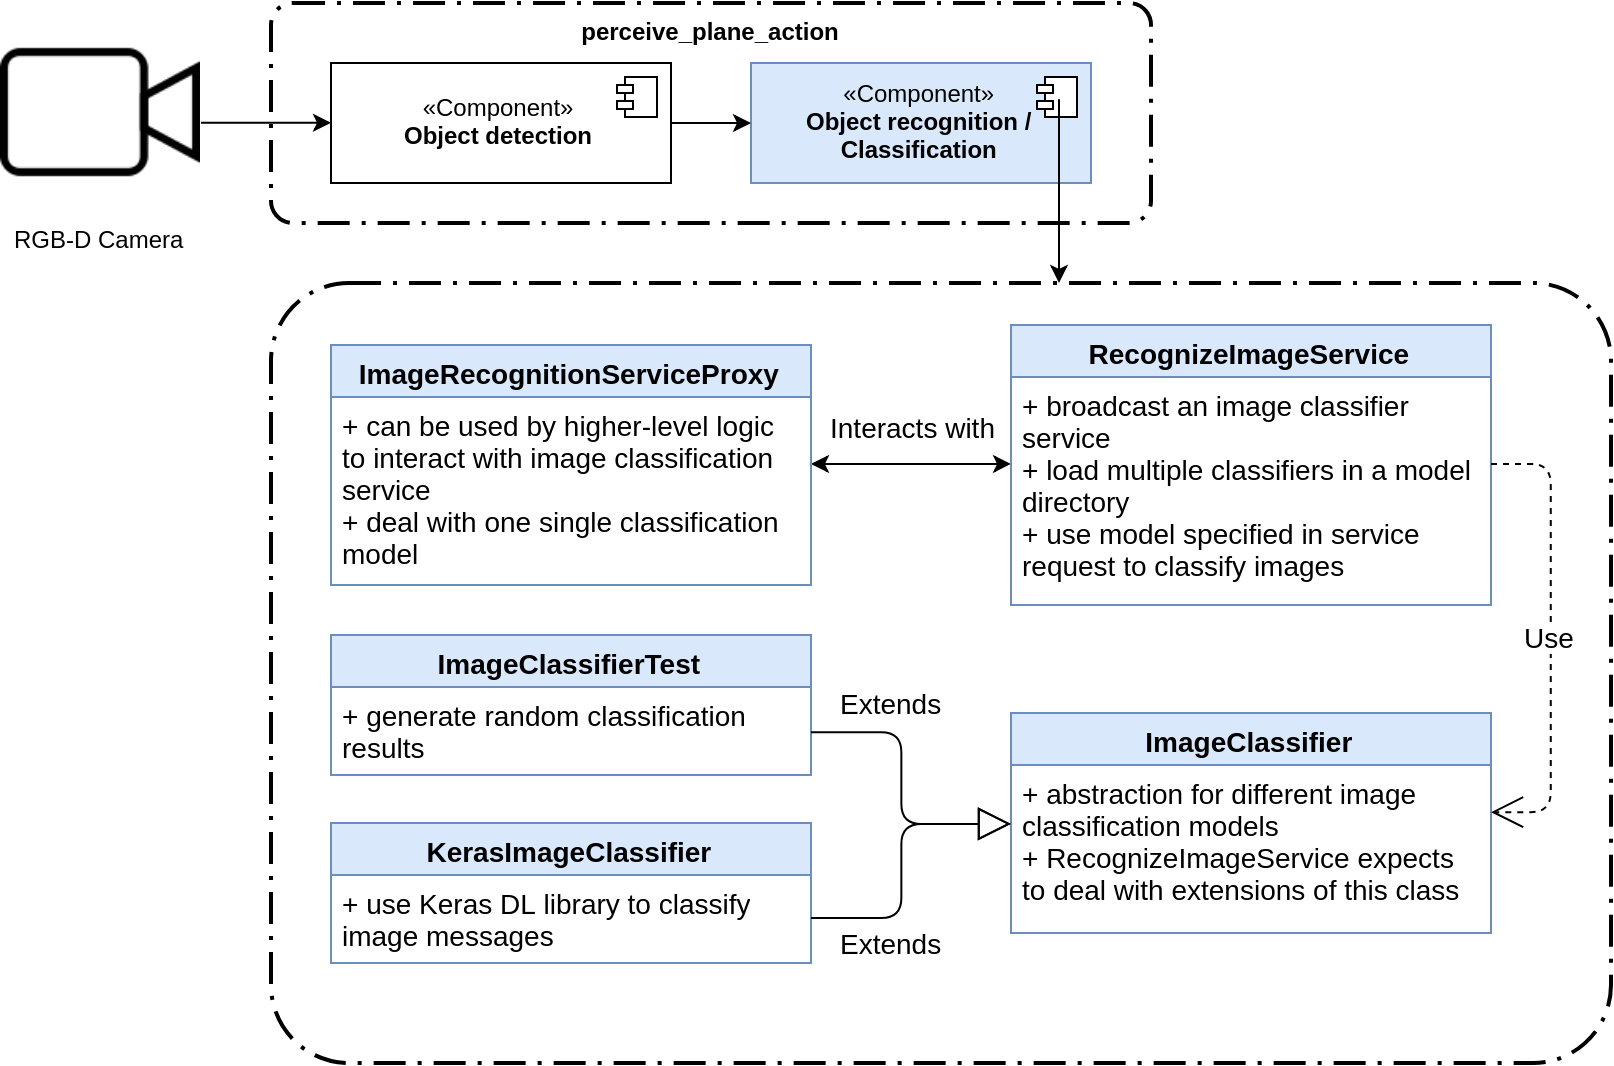

In [5]:
display.Image('images/perception_arch_recognition.png', width=750)

## `mas_perception_libs`

[`mas_perception_libs`](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/) is where almost all of the above components are defined (except for `SSDKerasObjectDetector`). Other than architectural code, the library also provides a common API for several functionalities in both C++ and Python, most notably point cloud processing.

The following section load in `sensor_msgs/PointCloud2` ROS messages from a bag file into a list. We will then experiment with one of these clouds. Because the quirky `rosbag` apparently stores messages in some mutated definition of the original messages, there's the need to serialize then deserialize the message for our next steps.

While this is not particularly important to perception functionalities, it's worthy to note that `from_cpp` and `to_cpp` are functions which imitate ROS serialization of messages, which are defined in [`mas_perception_libs`](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/ros/src/mas_perception_libs/ros_message_serialization.py). These and their sister functions in C++ are how the Python functions are able to call C++ code on all ROS messages. Any custom objects (i.e. [BoundingBox](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/docs/python_package.md#boundingbox2d)) requires implementation with Boost-Python (or other libraries).

In [6]:
import rosbag
from sensor_msgs.msg import PointCloud2
from mas_perception_libs.utils import from_cpp, to_cpp

cloud_bag = rosbag.Bag('data/sample_cloud.bag')
bag_topics = cloud_bag.get_type_and_topic_info()[1]
pointclouds = []
for topic, msg, t in cloud_bag.read_messages():
    if topic not in bag_topics or bag_topics[topic].msg_type != 'sensor_msgs/PointCloud2':
        continue
    pointclouds.append(msg)
cloud_bag.close()
cloud_msg = pointclouds[0]

print('Oh no type doesn\'t match:\t type(cloud_msg) == PointCloud2 ? ' + str(type(cloud_msg) == PointCloud2))

# some trickery required for converting the rosbag message type to the original type
cloud_msg = from_cpp(to_cpp(cloud_msg), PointCloud2)

print('All is good now:\t\t type(cloud_msg) == PointCloud2 ? ' + str(type(cloud_msg) == PointCloud2))

Oh no type doesn't match:	 type(cloud_msg) == PointCloud2 ? False
All is good now:		 type(cloud_msg) == PointCloud2 ? True


### Extract OpenCV image from a `sensor_msgs/PointCloud2` object
The following code illustrates how to use `cloud_msg_to_cv_image` to extract an image in the form of a NumPy array from a `sensor_msgs/PointCloud2`.

Image shape: (480, 640, 3), <type 'numpy.ndarray'>


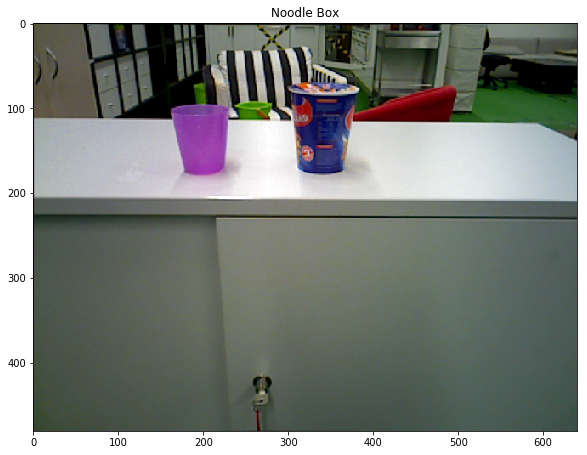

In [7]:
%matplotlib inline
from matplotlib import pyplot as plt
import cv2
from mas_perception_libs.utils import cloud_msg_to_cv_image

def display_image(img, fig_width, title):
    fig_width = float(fig_width)
    height, width, _ = img.shape
    fig = plt.figure(figsize=(fig_width, fig_width / width * height))
    plt.imshow(img)
    plt.title(title)
    plt.show()

cv_image = cloud_msg_to_cv_image(cloud_msg)
print('Image shape: {0}, {1}'.format(cv_image.shape, type(cv_image)))

# OpenCV has BGR instead of the RGB encoding that matplotlib expects
cv_image = cv2.cvtColor(cv_image, cv2.COLOR_BGR2RGB)
display_image(cv_image, 10, 'Noodle Box')

### Pose Estimation
Here we try to fit a pose to the noodle box, using a very educated guess of where it is in the image.

First we create the detection region using the `BoundingBox2D` class which [is defined in C++](https://github.com/b-it-bots/mas_perception/blob/devel/mas_perception_libs/docs/cpp_library.md#boundingbox2d) and ported to Python for a common API.

We can visualize this box using the `draw_labeled_boxes` function for OpenCV images, or `draw_labeled_boxes_img_msg` for `sensor_msgs/Image` objects.

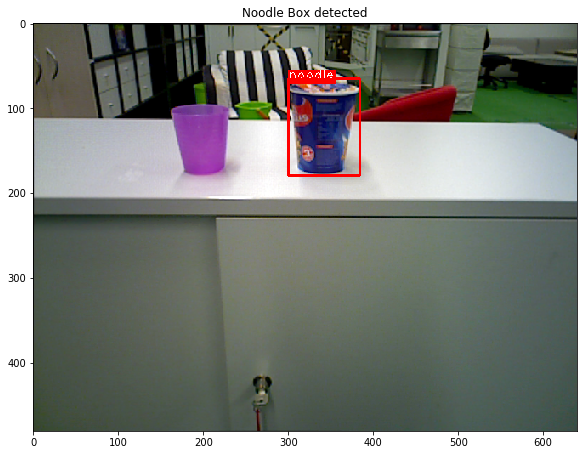

In [8]:
from mas_perception_libs import BoundingBox2D
from mas_perception_libs.visualization import draw_labeled_boxes

# detect regions in image to get a bounding box
detection = BoundingBox2D(label='noodle', box_geometry=(300, 65, 85, 115))  # (x, y, width, height)

# visualize box in image
drawn_image = draw_labeled_boxes(cv_image, [detection])
display_image(drawn_image, 10, 'Noodle Box detected')

Using the `BoundingBox2D` object we can then use `crop_cloud_to_xyz` to extract the 3D coordinates of the points within
this bouding box region. Pose estimation can then be done using `np.nanmean`. Note that `nanmean` will ignore `np.nan` values in the array.

In [9]:
import numpy as np
from mas_perception_libs.utils import crop_cloud_to_xyz

# crop cloud for coordinates and estimate pose
cropped_coord = crop_cloud_to_xyz(cloud_msg, detection)
mean_pose = np.nanmean(np.reshape(cropped_coord, (-1, 3)), axis=0)
print('estimated noodle box pose (frame {0}): x={1:.3f}, y={2:.3f}, z={3:.3f}'
      .format(cloud_msg.header.frame_id, mean_pose[0], mean_pose[1], mean_pose[2]))

estimated noodle box pose (frame head_rgbd_sensor_rgb_frame): x=0.029, y=-0.179, z=0.796


### SSD Object Detection

The following code block loads the `SSDKerasObjectDetector` class, uses the appropriate configuration files, and perform detection on the image extracted from the `sensor_msgs/PointCloud2` message.

`SSDKerasObjectDetector` is an extension of [`ImageDetectorBase`](https://github.com/minhnh/mas_perception/blob/devel/mas_perception_libs/docs/python_package.md#imagedetectorbase), which is used by [`SingleImageDetectionHandler`](https://github.com/minhnh/mas_perception/blob/devel/mas_perception_libs/docs/python_package.md#singleimagedetectionhandler) as can be seen in [the figure above](#Object-Detection).

As `SSDKerasObjectDetector.detect()` expects a list of `sensor_msgs/Image` objects, the `cloud_msg_to_image_msg` function is used to extract the image message from the `sensor_msgs/PointCloud2` message.

`SSDKerasObjectDetector.detect()` returns a list of detections for each image message. Each detection is a dictionary containing the detected class, detectioin confidence, and box pixel geometry, as printed out below. The keys of this dictionary are `Enum` values of `ImageDetectionKey` as shown below.

In [10]:
import os
from rospkg import RosPack
from mas_perception_libs import ImageDetectionKey
from mas_perception_libs.utils import cloud_msg_to_image_msg

# suppress tensorflow warning messages
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

from ssd_keras_ros import SSDKerasObjectDetector

# use RosPack to point to appropriate configuration files
rp = RosPack()
package_path = rp.get_path('ssd_keras_ros')
class_ann_file = os.path.join(package_path, 'models', 'coco_classes.yml')
kwargs_file = os.path.join(package_path, 'models', 'ssd_keras_object_detector_kwargs.yml')

# create SSDKerasObjectDetector object and call detection on 
detector = SSDKerasObjectDetector(class_file=class_ann_file, model_kwargs_file=kwargs_file)
predictions = detector.detect([cloud_msg_to_image_msg(cloud_msg)])

pred = predictions[0][0]
for enum_name, enum in ImageDetectionKey.__members__.iteritems():
    print('{}: {}'.format(enum_name, pred[enum]))
    

Using TensorFlow backend.


CLASS: cup
CONF: 0.953528821468
X_MIN: 161.73819987
X_MAX: 231.004378255
Y_MIN: 94.8230712891
Y_MAX: 176.401989746


`ImageDetectorBase.prediction_to_bounding_boxes()` can convert the above dictionary into `BoundingBox2D` objects, which can be used for the visualization function. `class_colors` is automatically generated for the classes.

Note: it may make sense to just use `BoundingBox2D` instead of dictionary for keeping track of detections.

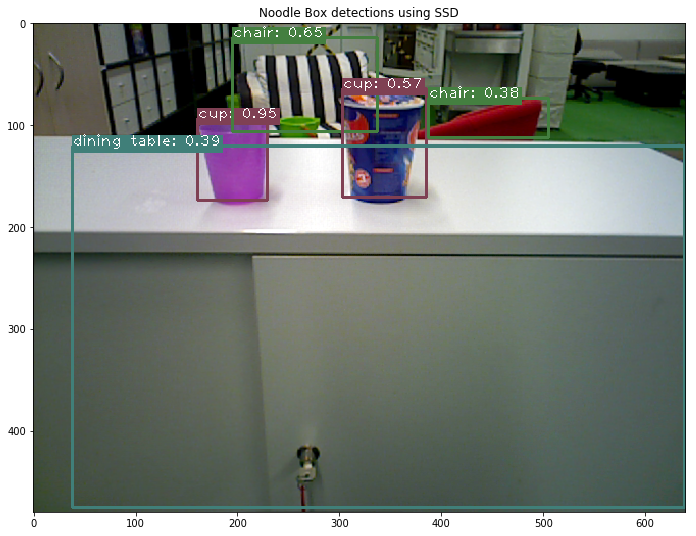

In [11]:
from mas_perception_libs import ImageDetectorBase

bounding_boxes, classes, confidences \
            = ImageDetectorBase.prediction_to_bounding_boxes(predictions[0], detector.class_colors)

ssd_image = draw_labeled_boxes(cv_image, bounding_boxes)
display_image(ssd_image, 12, 'Noodle Box detections using SSD')

### Point Cloud Processing
* C++ and Python usage comparison
* Rviz walk-through of plane fitting